# Convolutionnal Neural Network (CNN) Model for preventing ArUco tag occlusion

* #### author: Mowibox (Ousmane THIONGANE)
* #### date: December 29th, 2024

### Imports

In [44]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten

## Dataset preparation 

In [2]:
filepath = r'dataset/dataset.csv'
df = pd.read_csv(filepath, sep=",", header=0).copy()

display(df.head(5))
df.info()

,filename,x20,y20,x21,y21,x22,y22,x23,y23
0,img_0.png,225.00,253.50,472.00,144.25,234.50,370.50,516.25,281.75
1,img_1.png,224.75,251.75,475.25,141.00,234.25,369.75,519.75,282.25
2,img_2.png,225.00,253.75,474.25,142.25,234.50,372.75,518.00,285.00
3,img_3.png,333.25,263.00,558.00,181.00,331.25,364.50,585.00,312.50
4,img_4.png,266.00,258.25,461.25,166.50,271.25,359.25,489.75,294.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10078 entries, 0 to 10077
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  10078 non-null  object 
 1   x20       10078 non-null  float64
 2   y20       10078 non-null  float64
 3   x21       10078 non-null  float64
 4   y21       10078 non-null  float64
 5   x22       10078 non-null  float64
 6   y22       10078 non-null  float64
 7   x23       10078 non-null  float64
 8   y23       10078 non-null  float64
dtypes: float64(8), object(1)
memory usage: 708.7+ KB


We reduce the size of the images from (640, 480) to (320, 240):

In [ ]:
WIDTH = 0.5
HEIGHT = 0.5
dataset_size = 4000

df_subset = df_subset.sample(dataset_size)
X, y = [], []
for idx, row in df_subset.iterrows():
    img = cv2.imread(f"dataset/img/{row['filename']}")

    img = cv2.resize(img, (int(img.shape[1]*WIDTH), int(img.shape[0]*HEIGHT)))
    img = img / 255.0 # Data normalization
    X.append(img)

    label = row[1:].values.astype(float)  
    for i in range(0, len(label), 2):
        label[i] *= WIDTH  
        label[i + 1] *= HEIGHT  
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (4000, 240, 320, 3)
Labels shape: (4000, 8)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)

(3200, 240, 320, 3) (800, 240, 320, 3)


## CNN Model

In [5]:
model_cnn = Sequential()
model_cnn.add(Input(X_train[0].shape))
model_cnn.add(Conv2D(128, (3, 3), strides=2, activation='relu'))
model_cnn.add(MaxPool2D(3, 3))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPool2D(3, 3))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(MaxPool2D(3, 3))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(8, activation='linear'))

model_cnn.summary()

2025-01-01 01:23:43.138170: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 119, 159, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 51, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        61,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,800 (632.03 KB)

 Trainable params: 161,800 (632.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def EnsembleModel(ens_dim, input_shape, output_shape, base_width=16, depth=4):
    inputs = Input(shape=input_shape)

    learners = [CNN]

## Training and validation

In [6]:
model_cnn.compile(loss=MSE, optimizer=Adam(learning_rate=0.001), metrics=['mae'])

In [7]:
epochs = 100
history = model_cnn.fit(X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 278ms/step - loss: 11029.0293 - mae: 80.0280 - val_loss: 1151.3257 - val_mae: 26.9006
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - loss: 1116.2089 - mae: 26.1958 - val_loss: 998.3812 - val_mae: 24.7300
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - loss: 950.2984 - mae: 24.1830 - val_loss: 801.9905 - val_mae: 21.9097
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 272ms/step - loss: 809.5923 - mae: 22.2151 - val_loss: 711.0139 - val_mae: 20.5915
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - loss: 692.2999 - mae: 20.4709 - val_loss: 642.0115 - val_mae: 19.5094
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - loss: 630.3993 - mae: 19.4034 - val_loss: 529.5807 - val_mae: 17.6018
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - loss: 554.7725 - mae: 18.2200 - val_loss: 450.5225 - val_mae: 15.9292
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 282ms/step - loss: 467.9499 - mae: 16.6717 - val_loss: 

In [13]:
def displayLearningCurve(history, epochs: int, metric: str):
    """
    Displays the model learning curve (training & validation)

    @param history: The model history
    @param epochs: The number of epochs
    @param metric: The evaluated metric
    """
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history[metric])
    plt.plot(epoch_range, history.history[f'val_{metric}'])
    plt.title(f"Model {metric}")
    plt.ylabel(f'{metric}')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper right')

    plt.tight_layout()
    plt.show()

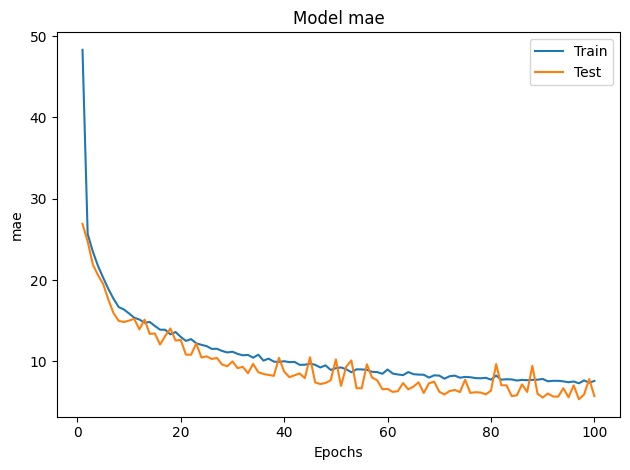

In [16]:
displayLearningCurve(history=history, epochs=epochs, metric='mae')

## Model visualisation

In [17]:
def display_img(img: np.ndarray, real_points: np.ndarray=[], predicted_points: np.ndarray=[]):
    """
    Displays the provided image on a plot
    Allows to compare real points between model prediction 

    @param img: The input image
    @param real_points: The center coordinates of the markers
    @param predicted_points: The predicted center coordinates
    """
    img =  (img*255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    for i in range(0, len(real_points), 2):  
        xr, yr = real_points[i], real_points[i + 1]
        ax.scatter(xr, yr, color='cyan', label='Real Points' if i == 0 else "")

    for i in range(0, len(predicted_points), 2):  
        xp, yp = predicted_points[i], predicted_points[i + 1]
        ax.scatter(xp, yp, color='red', marker='x', s=100, label='Predicted Points' if i == 0 else "")
        ax.set_title("Model prediction vs real values")
    ax.legend()
    ax.imshow(img)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


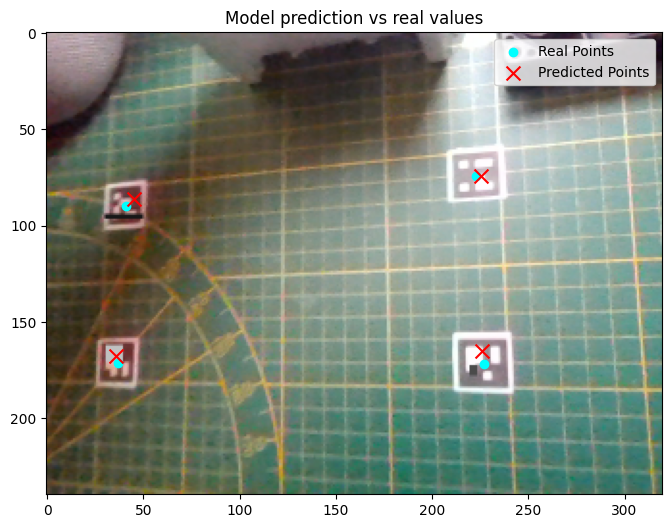

In [45]:
index = np.random.randint(0,1000)

row = df_subset.iloc[index]
filepath = f"dataset/img/{row['filename']}"
img = cv2.imread(filepath)
img = cv2.resize(img, (int(img.shape[1]*WIDTH), int(img.shape[0]*HEIGHT)))
img = img / 255.0

real_points = row[1:].values.astype(float)  
for i in range(0, len(real_points), 2):
    real_points[i] *= WIDTH  
    real_points[i + 1] *= HEIGHT  

predicted_points = model_cnn.predict(np.expand_dims(img, axis=0))[0]

display_img(img, real_points, predicted_points)

## Saving model

In [12]:
#model_cnn.save(filepath=f'cnn_model.keras')